# import

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import os
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/krakow-ta-restaurans-data-raw/TA_restaurants_curated.csv
/kaggle/input/cost-of-living/cost-of-living-2017.csv
/kaggle/input/cost-of-living/cost-of-living-2018.csv
/kaggle/input/cost-of-living/cost-of-living-2016.csv
/kaggle/input/world-cities-datasets/worldcities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [7]:
# также добавляю данные по городам - население, страна, столица, стоимость жизни.
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#cities_df = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')
#cost_df = pd.read_csv('/kaggle/input/cost-of-living/cost-of-living-2017.csv')
#ta_df = pd.read_csv('/kaggle/input/krakow-ta-restaurans-data-raw/TA_restaurants_curated.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [ ]:
# Попробовала добавить разные таблицы из базы kaggle.
# Но результат не понравился. Поэтому решила добавить списки со столицами, и популяцией.
# data.merge(cities_df, how = 'left', left_on='City', right_on='city_ascii')

In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(10)

In [ ]:
data.Reviews[1]

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data 

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [ ]:
data.info()

int64, float64 и object являются типами данных нашей таблицы. Мы видим, что одна особенность 7 столбцов имеет тип object, а оставшиеся являются числовыми. С помощью этого же метода мы можем легко увидеть, есть ли пропущенные значения - они есть в 4 столбцах.

In [ ]:
data.shape

Посмотрим подробнее на количество пропущенных значений.

In [ ]:
# Function to calculate missing values by column
def missing_values_table(data):
    # Total missing values
    mis_val = data.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * data.isnull().sum() / len(data)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Датафрейм содержит " + str(data.shape[1]) + " колонок.\n"
          "Есть " + str(mis_val_table_ren_columns.shape[0]) +
          " колонок с пропущенными значениями.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(27)

In [18]:
# добавляем столбцы для того, чтобы не потерять пропуски.
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('int64')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('int64')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('int64')

In [20]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0,0,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,0,0,0
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,0,0,1
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,0,0,0


Две колонки Price Range и Cuisine Style содержат большое количество пропусков - 34.7% и 23.2% соответственно. Ниже решим, как именно будем с ними работать. Целевая переменная Rating представлена без пропусков.

In [19]:
#посмотрим какие колонки есть в датасете
print(data.columns)

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'Number_of_Reviews_isNAN', 'Cuisine_Style_isNAN', 'Price_Range_isNAN'],
      dtype='object')


In [ ]:
#посмотрим на распределение числовых переменных
data.describe()

Пока не вижу в таблице никакой интересной информации. Целевая переменная варьируется от 0 до 5, основаня масса значение лежит от 3 до 4.5. Столбец sample не показателен, тк служебный. Видим достаточно большой разброс в столбце Number of Reviews (std расположено достаточно далеко от mean).

In [ ]:
data.Restaurant_id

Можно попробовать преобразовать эту колонку - убрать 'id_' - и поискать связь с целевой переменной.

## **Restaurant_id**

Отредактируем столбец так, чтобы от поля id_Значение осталось только Значение. Проверим, что колонка изменила тип с object на int64.

In [ ]:
data['Restaurant_id'][0][3:]

In [ ]:
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: x[3:])

In [ ]:
data['Restaurant_id'] = pd.to_numeric(data['Restaurant_id'], errors='coerce').fillna(0, downcast='infer')

In [ ]:
data['Restaurant_id'].value_counts(dropna=False)

In [ ]:
data.info()

Есть рестораны, которые встречаются только один раз в таблице, а есть, возможно, сетевые. Посмотрим подробнее.

In [ ]:
data[data.Restaurant_id=='id_633']

Посмотрела несколько первых значений и единственное, что нашла, что их объединяет - стобец sample - один из учебного, другие из тестового сета. У ресторанов из учебного сета похожий Ranking и Price Range.

Предположение - что id объединяет рестораны с похожим рейтингом или ценовым сегментом.

In [ ]:
data.groupby(['Restaurant_id'])['Rating'].count()

Чем ближе порядковый номер id к 0, тем большее количество ресторанов представлено в датасете.

In [ ]:
data.groupby(['Restaurant_id'])['Rating'].mean()

Предположим, что чем ближе порядковый номер id к 0, тем выше среднее значение. Проверим, с помощью гистограммы.

In [ ]:
data.groupby(['Restaurant_id'])['Rating'].mean().hist(bins=15)

Видим, что распределение похоже на нормальное с выбросом в 0 (это наша тестовая выборка). У большинства ресторанов рейтинг колеблется от 3 до 4 баллов, тоже самое мы видели, когда применили метод describe(). Предположение не подтвердилось. 

Посмотрим, есть ли связь между ресторанами, целевой переменной и рангом ресторана.

In [ ]:
data.groupby(['Restaurant_id'])['Ranking'].count()

In [ ]:
data.groupby(['Restaurant_id'])['Ranking'].mean()

В количестве ресторанов и их ранге картина похожая, что и в целевой переменной, а среднее распределение в столбце Ranking больше напоминает обратное целевой переменной. 

Проверим это предположение, построив гистограмму и посмотрев на распределение.

In [ ]:
data.groupby(['Restaurant_id'])['Ranking'].mean().hist(bins=15)

## **City**

In [ ]:
data.City

In [ ]:
#посмотрим сколько городов участвует в выборке
len(data.City.value_counts(dropna=False))

In [ ]:
print(data.groupby(['City'])['Rating'].count())
print(data.groupby(['City'])['Rating'].mean())
print(data.groupby(['City'])['Rating'].std())

Предположение - вне зависимости от численности соотношение плохих и хороших ресторанов будет примерно одинаковым.
Предположение - в столицах рестораны лучше.

Как видим, что общий разброс, что рейтинг - все примерно одинаково.

In [ ]:
sns.countplot(y='City', data=data, label='City')

Видно, что со значительным опережением в количестве ресторанов идут Лондон и Париж. 

Предположение - попробовать кодировать в хот и даммис и сравнить.

## **Cuisine Style**

In [ ]:
data['Cuisine Style'][3]

В ячейке список из кухонь, которые можно попробовать в ресторане. Лучше преобразовать столбец для дальнейшей работы.

Предположение - чем больше вариантов кухонь в одном ресторане, тем ниже рейтинг.
Предположение - нет связи между типом кухни и рейтингом.

In [ ]:
#посчитаем какое количество кухонь преставлено в одном ресторане
data['Cuisine Style'] = data['Cuisine Style'].str[2:-2].str.split("', '")
data['Cuisine count'] = data['Cuisine Style'].str.len()

In [ ]:
data

In [ ]:
# фильтруем нулевые значения
data[pd.isnull(data['Cuisine Style'])]

In [ ]:
# пробуем заменить все нулевые значения на none
data['Cuisine Style'].fillna("['none']", inplace=True)

Затем я хочу поместить каждое значение в поле 'Cuisine Style' в отдельную строку, соответсвующую ресторано. Преобразуем.

In [ ]:
prepared_data = data['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')).apply(pd.Series).merge(data, left_index=True, right_index=True) \
    .drop(['Cuisine Style'], axis=1)

In [ ]:
cusine_data = prepared_data.melt(id_vars=['Restaurant_id', 'City', 'Ranking', 'Price Range',
                                          'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'], value_name='cusine') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['cusine'])

In [ ]:
cusine_data.shape

После преобразований у нас осталось такое же количество столбцов, но количество строчек стало 131266.

In [ ]:
cusine_data.cusine.value_counts()

Всего в поле 'Cuisine Style' было представлено 126 уникальных значений, включая рестораны со значением 'none'. Не совсем понимаю, как их лучше преобразовать для модели, попробую объединить кухни, которые встречаются в 10% ресторанов или как-то сгруппировать их.

In [ ]:
European = ['European', 'Dutch', 'French', 'Central European', 'Italian', 'Irish',
            'German', 'Belgian', 'British', 'Spanish', 'Swiss', 'Scandinavian Middle']
Middle_Eastern = ['Mediterranean', 'Lebanese', 'Arabic',
                  'Turkish', 'Moroccan', 'Tunisian', 'Persian']
Asian = ['Asian', 'Indonesian', 'Japanese',
         'Chinese', 'Indian', 'Tibetan', 'Nepali', 'Thai']
Others = ['International', 'New Zealand', 'American',
          'Argentinean', 'South American', 'Latin']
Healthy_Options = ['Vegetarian Friendly',
                   'Vegan Options', 'Gluten Free Options', 'Healthy']
Bars = ['Bar', 'Pub', 'Wine Bar']
Specific = ['Diner', 'Cafe', 'Fast Food', 'Pizza', 'Seafood', 'Sushi', 'Soups',
            'Delicatessen', 'Contemporary', 'Halal', 'Grill', 'Barbecue', 'Steakhouse']


def cuisine_group(cuisines, cuisines_type):
    flag = 0
    if not isinstance(cuisines, float):
        for cuisine in ast.literal_eval(cuisines):
            if cuisine in cuisines_type:
                flag = 1
    return flag


data['european_group'] = data['Cuisine Style'].apply(
    cuisine_group, args=(European,))
data['middle_eastern_group'] = data['Cuisine Style'].apply(
    cuisine_group, args=(Middle_Eastern,))
data['asian_group'] = data['Cuisine Style'].apply(cuisine_group, args=(Asian,))
data['others_group'] = data['Cuisine Style'].apply(
    cuisine_group, args=(Others,))
data['healthy_options_group'] = data['Cuisine Style'].apply(
    cuisine_group, args=(Healthy_Options,))
data['bars_group'] = data['Cuisine Style'].apply(cuisine_group, args=(Bars,))
data['specific_group'] = data['Cuisine Style'].apply(
    cuisine_group, args=(Specific,))

In [ ]:
data

Посмотрим какое количество кухонь в представлено в среднем в ресторане.

In [ ]:
print(cusine_data.groupby(['ID_TA'])['cusine'].count().mean())

## **Reviews**

In [ ]:
#в столбце 'Reviews' находится 2 последних отзыва и даты этих отзывов
data['Reviews'][1]

In [ ]:
# посмотрим на нулевые значения в столбце Reviews
data[pd.isnull(data['Reviews'])]

In [ ]:
#фактически только два пропуска, но еще в таблице мы можем увидеть пустые значения в квадратных скобках []
#посмотрим сколько таких значенй
data.Reviews.value_counts()

In [ ]:
# применим функцию для обработки пропусков
def make_list(list_string):
    list_string = list_string.replace('nan]', "'This is Nan']")
    list_string = list_string.replace('[nan', "['This is Nan'")
    result_list = ast.literal_eval(list_string)
    return result_list


data['Reviews'] = data['Reviews'].fillna("[[], []]")
data['Reviews'] = data['Reviews'].apply(make_list)

In [ ]:
# создадим отдельный столбец для количества дней между отзывами
def delta_date(row):
    if len(row[1]) == 0 or len(row[1]) == 1:
        return 0

    elif len(row[1]) == 2:
        date1 = datetime.strptime(row[1][0], '%m/%d/%Y')
        date2 = datetime.strptime(row[1][1], '%m/%d/%Y')
        return abs(date1 - date2).days


data['Days between reviews'] = data['Reviews'].apply(delta_date)

In [ ]:
current_date_dt = datetime.strptime('07/26/2020', '%m/%d/%Y')


def since_last_days(row):
    if len(row[1]) == 0:
        date = datetime.strptime('01/01/2000', '%m/%d/%Y')

    elif len(row[1]) == 1:
        date = datetime.strptime(row[1][0], '%m/%d/%Y')

    else:
        date1 = datetime.strptime(row[1][0], '%m/%d/%Y')
        date2 = datetime.strptime(row[1][1], '%m/%d/%Y')
        date = max(date1, date2)

    return (current_date_dt - date).days


data['Days since last review'] = data['Reviews'].apply(since_last_days)

Также попробоавал создать отдельный столбец с датами, но предыдущий вариант оказался эффективнее.

In [ ]:
# заменим их
data['Reviews'].fillna("[[],[]]", inplace=True)

In [ ]:
# вытащим дату отзывов в отдельный столбец
prep_data = data['Reviews'].apply(lambda x: x.strip(
    '][').partition('], [')[2].split(', ')).apply(pd.Series)

In [ ]:
prep_data = prep_data.merge(data, left_index=True, right_index=True)

In [ ]:
todatetime_data = prep_data.melt(id_vars=['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
                                          'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'], value_name='date') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['date'])

In [ ]:
# преобразуем значения в дату
todatetime_data['date'] = pd.to_datetime(todatetime_data['date']).astype(int)

In [ ]:
todatetime_data['date'] = todatetime_data['date'].apply(lambda x: if type(x) == 'datetime' int(x.timestamp() * 1000))

## **Price Range**

In [ ]:
# Цены в ресторане представлены в 3 категориях
data['Price Range']

Предположим, что чем дороже ресторан, тем выше у него рейтинг. 

In [ ]:
data['Price Range'].value_counts(dropna=False, normalize=True)

In [ ]:
print(data.groupby(['Price Range'])['Rating'].count())
print(data.groupby(['Price Range'])['Rating'].mean())
print(data.groupby(['Price Range'])['Rating'].std())

Больше всего ресторанов представлено в среднем ценовом сегменте. Среднее и среднее квадратическое отклонение целевой переменной составляют около 3.3 и 1.7, вне зависимости от ценового сегмента. Поэтому предположение о связи рейтинга и стоимости меню в ресторане не подтвердилось. 

In [ ]:
data[pd.isnull(data['Price Range'])]

In [ ]:
# попробуем заполнить пропуски на наиболее частотное значение
data['Price Range'].fillna("$$ - $$$", inplace=True)

Далее перекодируем переменную в числовой вид и посмотрим боксплот.

## **URL_TA и ID_TA**

In [ ]:
# страница ресторана на 'www.tripadvisor.com'
data['URL_TA'][0]

Не уверена, что этот столбец нужен, но можно попробовать вытащить из ссылки название ресторана и предположить, что чем больше букв в названии, тем выше рейтинг.

In [ ]:
# ID ресторана в TripAdvisor
data['ID_TA']

In [ ]:
# уберем первый символ, чтобы осталось только числовое значение
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

In [ ]:
data['ID_TA'].value_counts()

## **Ranking**

In [ ]:
# Ранг ресторана относительно других ресторанов в этом городе
data['Ranking'].describe()

In [ ]:
print(data.groupby(['Ranking'])['Rating'].count())
print(data.groupby(['Ranking'])['Rating'].mean())
print(data.groupby(['Ranking'])['Rating'].std())

In [ ]:
data['Ranking'].value_counts(dropna=False, normalize=True)

In [ ]:
sns.boxplot(data['Ranking'])

Если я правильно поняла, то чем выше ранг ресторана, тем лучше. По боксплоту видим, что большинство ресторанов занимают позицию от 1000 до 5200, а максимально возможная - 16444.

## **Rating**

In [ ]:
# целевая переменная
data['Rating']

In [ ]:
data['Rating'].value_counts(dropna=False, normalize=True)

In [ ]:
sns.boxplot(data['Rating'])

Целевая перемення представлена из двух наборов данных - тест и трейн. В учебном наборе преобладают рестораны с отзывами 3.5, 4.5, 4.0.

## **Number of Reviews**

In [ ]:
# Количество отзывов
data['Number of Reviews']

In [ ]:
data['Number of Reviews'].value_counts(dropna=False, normalize=True)

In [ ]:
print(data.groupby(['Number of Reviews'])['Rating'].count())
print(data.groupby(['Number of Reviews'])['Rating'].mean())
print(data.groupby(['Number of Reviews'])['Rating'].std())

In [ ]:
data[pd.isnull(data['Number of Reviews'])]

In [ ]:
data.groupby('Rating')['Number of Reviews'].describe()

Похоже, что больше всео отзывов у ресторанов, которым ставят оценку 3.5, 4.0 и 4.5

In [ ]:
# заполним пропуски средним по городу
data['Number of Reviews'] = data.apply(lambda row: data[data.City == row.City]
                                       ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)

In [ ]:
data.groupby('Number of Reviews')['Rating'].count().hist(bins=15)

In [ ]:
sns.boxplot(data['Number of Reviews'])

Что по боксплоту, что по гистограмме - можно сделать предположение, что чаще всего клиенты не оставляют отзывы. Предположим, что чем лучше ресторан, тем больше у него отзывов.

In [ ]:
# здесь подбирала такое количество отзывов, чтобы построить более
# показательную гистограмму и посмотреть распределение, вместе с
# тестовым набором
is_reviews = data.loc[data['Number of Reviews'] > 1000]

In [ ]:
is_reviews

In [ ]:
is_reviews['Number of Reviews'].hist(bins=100)

In [ ]:
is_reviews.groupby('Number of Reviews')['Rating'].count().hist(bins=15)

In [ ]:
is_rating = data.loc[data['Rating'] > 0]

In [ ]:
is_rating['Rating'].hist(bins=100)

In [ ]:
is_rating.groupby('Number of Reviews')['Rating'].count().hist(bins=15)

Ощущаю, что я запуталась. Пыталась посмотреть связь количества отзывов и оценки у ресторана. Похоже, что предположение о том, что чем больше рейтинг у ресторана, тем больше отзывов не подтвердилось. 

In [ ]:
#data.pivot_table(index='City', columns='Number of Reviews', стр 213)

# Добавляем новые признаки

In [ ]:
# Add capital sity 0 or 1, 'Edinburgh' is not capital

capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg', ]


def is_capital(city):
    if city in capitals:
        return 1
    else:
        return 0


data['is_capital'] = data['City'].apply(is_capital)

In [ ]:
# население
cities = {
    'London': 8567000,
    'Paris': 9904000,
    'Madrid': 5567000,
    'Barcelona': 4920000,
    'Berlin': 3406000,
    'Milan': 2945000,
    'Rome': 3339000,
    'Prague': 1162000,
    'Lisbon': 2812000,
    'Vienna': 2400000,
    'Amsterdam': 1031000,
    'Brussels': 1743000,
    'Hamburg': 1757000,
    'Munich': 1275000,
    'Lyon': 1423000,
    'Stockholm': 1264000,
    'Budapest': 1679000,
    'Warsaw': 1707000,
    'Dublin': 1059000,
    'Copenhagen': 1085000,
    'Athens': 3242000,
    'Edinburgh': 504966,
    'Zurich': 1108000,
    'Oporto': 1337000,
    'Geneva': 1240000,
    'Krakow': 756000,
    'Oslo': 835000,
    'Helsinki': 1115000,
    'Bratislava': 423737,
    'Luxembourg': 107260,
    'Ljubljana': 314807,
}

data['Population'] = data['City'].map(cities)

In [ ]:
rest_count = data.groupby('City')['Restaurant_id'].count().to_dict()
data['Total count of restaurants'] = data['City'].map(rest_count)
data['People per restaurant'] = data['Population'] / \
    data['Total count of restaurants']

In [ ]:
data

In [ ]:
countries = {
    'London': 'GB',
    'Paris': 'FR',
    'Madrid': 'ES',
    'Barcelona': 'ES',
    'Berlin': 'DE',
    'Milan': 'IT',
    'Rome': 'IT',
    'Prague': 'CZ',
    'Lisbon': 'PT',
    'Vienna': 'AT',
    'Amsterdam': 'NL',
    'Brussels': 'BE',
    'Hamburg': 'DE',
    'Munich': 'DE',
    'Lyon': 'FR',
    'Stockholm': 'SE',
    'Budapest': 'HU',
    'Warsaw': 'PL',
    'Dublin': 'IE',
    'Copenhagen': 'DK',
    'Athens': 'GR',
    'Edinburgh': 'GB',
    'Zurich': 'CH',
    'Oporto': 'PT',
    'Geneva': 'CH',
    'Krakow': 'PL',
    'Oslo': 'NO',
    'Helsinki': 'FI',
    'Bratislava': 'SK',
    'Luxembourg': 'LU',
    'Ljubljana': 'SI',
}

data['Country'] = data['City'].map(countries)

In [ ]:
data['Country'].value_counts()

In [ ]:
restaurant_chain = set()
for chain in data['Restaurant_id']:
    restaurant_chain.update(chain)


def find_item1(cell):
    if item in cell:
        return 1
    return 0


for item in restaurant_chain:
    data['Restaurant chain'] = data['Restaurant_id'].apply(find_item1)

## Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [ ]:
data.nunique(dropna=False)

In [ ]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=['City', ], dummy_na=True)

In [ ]:
data.head(5)

In [ ]:
data.sample(5)

## Возьмем следующий признак "Price Range".

In [ ]:
data['Price Range'].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()

In [ ]:
data['pr_range'] = pd.Series(label_encoder.fit_transform(data['Price Range']))
data.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

Не могу понять почему не срабатывает LabelEncoder, в общей функции ниже новая колонка создается. 

Предположим, что чем дороже ресторан, тем выше у него рейтинг.

In [ ]:
data.loc[data['Price Range'] == '$', 'Price Range'] = 1
data.loc[data['Price Range'] == '$$ - $$$', 'Price Range'] = 2
data.loc[data['Price Range'] == '$$$$', 'Price Range'] = 3

In [ ]:
data['Price Range'].fillna(2, inplace=True)

In [ ]:
data.groupby('Price Range')['Rating'].count().hist()

In [ ]:
data.groupby('Rating')['Price Range'].count().hist()

In [ ]:
# также трансформируем столбец со значением Country
countries_le = LabelEncoder()
countries_le.fit(data['Country'])
data['Country Code'] = countries_le.transform(data['Country'])

In [ ]:
data

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

## Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] == 'London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


## Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

## Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

## И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# функция для примера
# МАЕ - 0.43
def preproc_data_0(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

In [ ]:
# Участвую столбцы 'Ranking', 'Number of Reviews', 'sample', 'Rating',
#        'pr_range', 'City_-all-'
# MAE - 0.026
def preproc_data_1(df_input, row_count = None):
    '''includes several functions to pre-process the predictor data.'''
    
    if row_count is not None:
        df_output = df_input.head(row_count).copy()
    else:
        df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#   df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['Cuisine Style'].fillna("['none']", inplace=True)
    df_output['Reviews'].fillna("[[],[]]", inplace=True)
    df_output['Restaurant_id'] = df_output['Restaurant_id'].apply(lambda x: x[3:])
    
    
#     Price range
    df_output['Price Range'].fillna("$$ - $$$", inplace=True)
    df_output['pr_range'] = pd.Series(label_encoder.fit_transform(df_output['Price Range']))
    
#     Number of reviews
    df_output['Number of Reviews'] = df_output \
     .apply(lambda row: df_output[df_output.City==row.City] \
            ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)
    
#     Cusine style
    prepared_data=df_output['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Cuisine Style'], axis=1)
    
    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'pr_range'], value_name = 'cusine') \
      .drop(['variable'], axis=1) \
      .dropna(subset=['cusine'])
    
#     Reviews
    prepared_data=df_output['Reviews'].apply(lambda x: x.strip('][').partition('], [')[2].split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Reviews'], axis=1)

    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'cusine', 'pr_range'], value_name = 'date') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['date'])

    df_output['date'] = pd.to_datetime(df_output['date'])
    
    #df_output['cusine_1'] = pd.Series(label_encoder.fit_transform(df_output['cusine']))
    

    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)

    
    
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(['date'], axis = 1, inplace=True)
    
    return df_output

In [ ]:
# Участвую столбцы 'Ranking', 'Number of Reviews', 'sample', 'Rating', 'pr_range',
#        'City_','cusine_'''
# MAE = 0.044 (добавленные через даммис без какой-либо обработки кухни ухудшили результат и не одна из кухонь не была определена, как важная)
def preproc_data_2(df_input, row_count = None):
    '''includes several functions to pre-process the predictor data.'''
    
    if row_count is not None:
        df_output = df_input.head(row_count).copy()
    else:
        df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#   df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['Cuisine Style'].fillna("['none']", inplace=True)
    df_output['Reviews'].fillna("[[],[]]", inplace=True)
    df_output['Restaurant_id'] = df_output['Restaurant_id'].apply(lambda x: x[3:])
    
    
#     Price range
    df_output['Price Range'].fillna("$$ - $$$", inplace=True)
    df_output['pr_range'] = pd.Series(label_encoder.fit_transform(df_output['Price Range']))
    
#     Number of reviews
    df_output['Number of Reviews'] = df_output \
     .apply(lambda row: df_output[df_output.City==row.City] \
            ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)
    
#     Cusine style
    prepared_data=df_output['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Cuisine Style'], axis=1)
    
    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'pr_range'], value_name = 'cusine') \
      .drop(['variable'], axis=1) \
      .dropna(subset=['cusine'])
    
#     Reviews
    prepared_data=df_output['Reviews'].apply(lambda x: x.strip('][').partition('], [')[2].split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Reviews'], axis=1)

    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'cusine', 'pr_range'], value_name = 'date') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['date'])

    df_output['date'] = pd.to_datetime(df_output['date'])
    
    #df_output['cusine_1'] = pd.Series(label_encoder.fit_transform(df_output['cusine']))
    

    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    df_output = pd.get_dummies(df_output, columns=[ 'cusine',], dummy_na=True)

    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(['date'], axis = 1, inplace=True)
    
    return df_output

In [ ]:
# Участвую столбцы 'Number of Reviews', 'sample', 'Rating', 'pr_range',
#        'City_'
# MAE = 0.276 (убрала столбец Ranking, повысилась важность Number of Reviews и pr_range)
def preproc_data_3(df_input, row_count = None):
    '''includes several functions to pre-process the predictor data.'''
    
    if row_count is not None:
        df_output = df_input.head(row_count).copy()
    else:
        df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#   df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['Cuisine Style'].fillna("['none']", inplace=True)
    df_output['Reviews'].fillna("[[],[]]", inplace=True)
    df_output['Restaurant_id'] = df_output['Restaurant_id'].apply(lambda x: x[3:])
    
    
#     Price range
    df_output['Price Range'].fillna("$$ - $$$", inplace=True)
    df_output['pr_range'] = pd.Series(label_encoder.fit_transform(df_output['Price Range']))
    
#     Number of reviews
    df_output['Number of Reviews'] = df_output \
     .apply(lambda row: df_output[df_output.City==row.City] \
            ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)
    
#     Cusine style
    prepared_data=df_output['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Cuisine Style'], axis=1)
    
    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'pr_range'], value_name = 'cusine') \
      .drop(['variable'], axis=1) \
      .dropna(subset=['cusine'])
    
#     Reviews
    prepared_data=df_output['Reviews'].apply(lambda x: x.strip('][').partition('], [')[2].split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Reviews'], axis=1)

    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'cusine', 'pr_range'], value_name = 'date') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['date'])

    df_output['date'] = pd.to_datetime(df_output['date'])
    
    #df_output['cusine_1'] = pd.Series(label_encoder.fit_transform(df_output['cusine']))
    

    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(['date', 'Ranking'], axis = 1, inplace=True)
    
    return df_output

In [ ]:
# Участвую столбцы 'Restaurant_id', 'Number of Reviews', 'sample', 'Rating', 'pr_range',
#        'City_'
# MAE = 0.0269 (Restaurant_id добавила - оказался значимым столбцом, 'Ranking' так и не добавляла)
def preproc_data_4(df_input, row_count = None):
    '''includes several functions to pre-process the predictor data.'''
    
    if row_count is not None:
        df_output = df_input.head(row_count).copy()
    else:
        df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#   df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['Cuisine Style'].fillna("['none']", inplace=True)
    df_output['Reviews'].fillna("[[],[]]", inplace=True)
    df_output['Restaurant_id'] = df_output['Restaurant_id'].apply(lambda x: x[3:])
    
    df_output['Restaurant_id'] = pd.to_numeric(df_output['Restaurant_id'], errors='coerce').fillna(0, downcast='infer')
    
    
#     Price range
    df_output['Price Range'].fillna("$$ - $$$", inplace=True)
    df_output['pr_range'] = pd.Series(label_encoder.fit_transform(df_output['Price Range']))
    
#     Number of reviews
    df_output['Number of Reviews'] = df_output \
     .apply(lambda row: df_output[df_output.City==row.City] \
            ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)
    
#     Cusine style
    prepared_data=df_output['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Cuisine Style'], axis=1)
    
    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'pr_range'], value_name = 'cusine') \
      .drop(['variable'], axis=1) \
      .dropna(subset=['cusine'])
    
#     Reviews
    prepared_data=df_output['Reviews'].apply(lambda x: x.strip('][').partition('], [')[2].split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Reviews'], axis=1)

    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'cusine', 'pr_range'], value_name = 'date') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['date'])

    df_output['date'] = pd.to_datetime(df_output['date'])
    
    #df_output['cusine_1'] = pd.Series(label_encoder.fit_transform(df_output['cusine']))
    

    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(['date', 'Ranking'], axis = 1, inplace=True)
    
    return df_output

In [ ]:
# Участвую столбцы 'Restaurant_id', 'Number of Reviews', 'sample', 'Rating', 'pr_range', 
#        'City_', 'Ranking'
# MAE = 0.269 (Restaurant_id добавила - оказался значимым столбцом, 'Ranking' тоже значимый)
def preproc_data_5(df_input, row_count = None):
    '''includes several functions to pre-process the predictor data.'''
    
    if row_count is not None:
        df_output = df_input.head(row_count).copy()
    else:
        df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#   df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['Cuisine Style'].fillna("['none']", inplace=True)
    df_output['Reviews'].fillna("[[],[]]", inplace=True)
    df_output['Restaurant_id'] = df_output['Restaurant_id'].apply(lambda x: x[3:])
    
    df_output['Restaurant_id'] = pd.to_numeric(df_output['Restaurant_id'], errors='coerce').fillna(0, downcast='infer')
    
    
#     Price range
    df_output['Price Range'].fillna("$$ - $$$", inplace=True)
    df_output['pr_range'] = pd.Series(label_encoder.fit_transform(df_output['Price Range']))
    
#     Number of reviews
    df_output['Number of Reviews'] = df_output \
     .apply(lambda row: df_output[df_output.City==row.City] \
            ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)
    
#     Cusine style
    prepared_data=df_output['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Cuisine Style'], axis=1)
    
    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'pr_range'], value_name = 'cusine') \
      .drop(['variable'], axis=1) \
      .dropna(subset=['cusine'])
    
#     Reviews
    prepared_data=df_output['Reviews'].apply(lambda x: x.strip('][').partition('], [')[2].split(', ')) \
      .apply(pd.Series) \
      .merge(df_output, left_index = True, right_index = True) \
      .drop(['Reviews'], axis=1)

    df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'cusine', 'pr_range'], value_name = 'date') \
    .drop(['variable'], axis=1) \
    .dropna(subset=['date'])

    df_output['date'] = pd.to_datetime(df_output['date'])
    
    #df_output['cusine_1'] = pd.Series(label_encoder.fit_transform(df_output['cusine']))
    

    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(['date'], axis = 1, inplace=True)
    
    return df_output

In [62]:
# собираем в одну функцию
def preproc_data_6(df_input, row_count=None):
    '''includes several functions to pre-process the predictor data.'''

    if row_count is not None:
        df_output = df_input.head(row_count).copy()
    else:
        df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
#   df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

    # ################### 2. NAN ##############################################################
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number of Reviews']).astype('uint8')
    df_output['Cuisine_Style_isNAN'] = pd.isna(
        df_output['Cuisine Style']).astype('uint8')
    df_output['Price_Range_isNAN'] = pd.isna(
        df_output['Price Range']).astype('uint8')

    df_output['Cuisine Style'].fillna("['none']", inplace=True)
    df_output['Reviews'].fillna("[[],[]]", inplace=True)

    European = ['European', 'Dutch', 'French', 'Central European', 'Italian', 'Irish',
                'German', 'Belgian', 'British', 'Spanish', 'Swiss', 'Scandinavian Middle']
    Middle_Eastern = ['Mediterranean', 'Lebanese', 'Arabic',
                      'Turkish', 'Moroccan', 'Tunisian', 'Persian']
    Asian = ['Asian', 'Indonesian', 'Japanese',
             'Chinese', 'Indian', 'Tibetan', 'Nepali', 'Thai']
    Others = ['International', 'New Zealand', 'American',
              'Argentinean', 'South American', 'Latin']
    Healthy_Options = ['Vegetarian Friendly',
                       'Vegan Options', 'Gluten Free Options', 'Healthy']
    Bars = ['Bar', 'Pub', 'Wine Bar']
    Specific = ['Diner', 'Cafe', 'Fast Food', 'Pizza', 'Seafood', 'Sushi', 'Soups',
                'Delicatessen', 'Contemporary', 'Halal', 'Grill', 'Barbecue', 'Steakhouse']

    def cuisine_group(cuisines, cuisines_type):
        flag = 0
        if not isinstance(cuisines, float):
            for cuisine in ast.literal_eval(cuisines):
                if cuisine in cuisines_type:
                    flag = 1
        return flag

    df_output['european_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(European,))
    df_output['middle_eastern_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(Middle_Eastern,))
    df_output['asian_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(Asian,))
    df_output['others_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(Others,))
    df_output['healthy_options_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(Healthy_Options,))
    df_output['bars_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(Bars,))
    df_output['specific_group'] = df_output['Cuisine Style'].apply(
        cuisine_group, args=(Specific,))

    df_output['Cuisine Style'] = df_output['Cuisine Style'].str[2:-
                                                                2].str.split("', '")
    df_output['Cuisine count'] = df_output['Cuisine Style'].str.len()

#     Price range
    df_output['Price Range'].fillna("$$ - $$$", inplace=True)
    df_output['pr_range'] = pd.Series(
        label_encoder.fit_transform(df_output['Price Range']))

#     Number of reviews
    df_output['Number of Reviews'] = df_output \
        .apply(lambda row: df_output[df_output.City == row.City]
               ['Number of Reviews'].median() if pd.isna(row['Number of Reviews']) else row['Number of Reviews'], axis=1)

# #     Cusine style
#     prepared_data=df_output['Cuisine Style'].apply(lambda x: x.strip('][').split(', ')) \
#       .apply(pd.Series) \
#       .merge(df_output, left_index = True, right_index = True) \
#       .drop(['Cuisine Style'], axis=1)

#     df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
#        'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'pr_range', 'Number_of_Reviews_isNAN',
#                                          'Price_Range_isNAN', 'Cuisine_Style_isNAN', ], value_name = 'cusine') \
#       .drop(['variable'], axis=1) \
#       .dropna(subset=['cusine'])

# #     Reviews
#     prepared_data=df_output['Reviews'].apply(lambda x: x.strip('][').partition('], [')[2].split(', ')) \
#       .apply(pd.Series) \
#       .merge(df_output, left_index = True, right_index = True) \
#       .drop(['Reviews'], axis=1)
# #    Date
#     df_output = prepared_data.melt(id_vars = ['Restaurant_id', 'City', 'Ranking', 'Price Range',
#        'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'cusine', 'pr_range'], value_name = 'date') \
#     .drop(['variable'], axis=1) \
#     .dropna(subset=['date'])

#     df_output['date'] = pd.to_datetime(df_output['date'])

    #df_output['cusine_1'] = pd.Series(label_encoder.fit_transform(df_output['cusine']))

#     Capitals
    capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
                'Bratislava', 'Vienna', 'Rome', 'Madrid',
                'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
                'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
                'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg', ]

    def is_capital(city):
        if city in capitals:
            return 1
        else:
            return 0

    df_output['is_capital'] = df_output['City'].apply(is_capital)

#     Population
    cities = {
        'London': 8567000, 'Paris': 9904000, 'Madrid': 5567000, 'Barcelona': 4920000, 'Berlin': 3406000, 'Milan': 2945000,
        'Rome': 3339000, 'Prague': 1162000, 'Lisbon': 2812000, 'Vienna': 2400000, 'Amsterdam': 1031000, 'Brussels': 1743000,
        'Hamburg': 1757000, 'Munich': 1275000, 'Lyon': 1423000,
        'Stockholm': 1264000, 'Budapest': 1679000, 'Warsaw': 1707000, 'Dublin': 1059000,
        'Copenhagen': 1085000, 'Athens': 3242000, 'Edinburgh': 504966, 'Zurich': 1108000,
        'Oporto': 1337000, 'Geneva': 1240000, 'Krakow': 756000, 'Oslo': 835000, 'Helsinki': 1115000,
        'Bratislava': 423737, 'Luxembourg': 107260, 'Ljubljana': 314807,
    }

    df_output['Population'] = df_output['City'].map(cities)

    rest_count = df_output.groupby('City')['Restaurant_id'].count().to_dict()
    df_output['Total count of restaurants'] = df_output['City'].map(rest_count)
    df_output['People per restaurant'] = df_output['Population'] / \
        df_output['Total count of restaurants']

#     Countries
    countries = {
        'London': 'GB', 'Paris': 'FR', 'Madrid': 'ES', 'Barcelona': 'ES', 'Berlin': 'DE', 'Milan': 'IT',
        'Rome': 'IT', 'Prague': 'CZ', 'Lisbon': 'PT', 'Vienna': 'AT', 'Amsterdam': 'NL', 'Brussels': 'BE',
        'Hamburg': 'DE', 'Munich': 'DE', 'Lyon': 'FR', 'Stockholm': 'SE', 'Budapest': 'HU', 'Warsaw': 'PL',
        'Dublin': 'IE', 'Copenhagen': 'DK', 'Athens': 'GR', 'Edinburgh': 'GB', 'Zurich': 'CH', 'Oporto': 'PT',
        'Geneva': 'CH', 'Krakow': 'PL', 'Oslo': 'NO', 'Helsinki': 'FI', 'Bratislava': 'SK', 'Luxembourg': 'LU',
        'Ljubljana': 'SI',
    }

    df_output['Country'] = df_output['City'].map(countries)
    countries_le = LabelEncoder()
    countries_le.fit(df_output['Country'])
    df_output['Country Code'] = countries_le.transform(df_output['Country'])

    df_output['ID_TA'] = df_output['ID_TA'].apply(lambda x: int(x[1:]))

#     Restaurant chain
    restaurant_chain = set()
    for chain in df_output['Restaurant_id']:
        restaurant_chain.update(chain)

    def find_item1(cell):
        if item in cell:
            return 1
        return 0

    for item in restaurant_chain:
        df_output['Restaurant chain'] = df_output['Restaurant_id'].apply(
            find_item1)

#        id
    df_output['Restaurant_id'] = df_output['Restaurant_id'].apply(
        lambda x: x[3:])
    df_output['Restaurant_id'] = pd.to_numeric(
        df_output['Restaurant_id'], errors='coerce').fillna(0, downcast='infer')

#     Reviews
    def make_list(list_string):
        list_string = list_string.replace('nan]', "'This is Nan']")
        list_string = list_string.replace('[nan', "['This is Nan'")
        result_list = ast.literal_eval(list_string)
        return result_list

    df_output['Reviews'] = df_output['Reviews'].fillna("[[], []]")
    df_output['Reviews'] = df_output['Reviews'].apply(make_list)

#     Date
    def delta_date(row):
        if len(row[1]) == 0 or len(row[1]) == 1:
            return 0

        elif len(row[1]) == 2:
            date1 = datetime.strptime(row[1][0], '%m/%d/%Y')
            date2 = datetime.strptime(row[1][1], '%m/%d/%Y')
        return abs(date1 - date2).days

    df_output['Days between reviews'] = df_output['Reviews'].apply(delta_date)

#     current_date_dt = datetime.strptime('07/26/2020','%m/%d/%Y')

#     def since_last_days(row):
#         if len(row[1]) == 0:
#             date = datetime.strptime('01/01/2000','%m/%d/%Y')

#         elif len(row[1]) == 1:
#             date = datetime.strptime(row[1][0],'%m/%d/%Y')

#         else:
#             date1 = datetime.strptime(row[1][0],'%m/%d/%Y')
#             date2 = datetime.strptime(row[1][1],'%m/%d/%Y')
#             date = max(date1, date2)

#         return (current_date_dt - date).days

#     data['Days since last review'] = df_output['Reviews'].apply(since_last_days)

    # ################### 3. Encoding ##############################################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#     df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)

    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим

    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)
    #df_output.drop(['date'], axis = 1, inplace=True)

    return df_output

In [63]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [64]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import ast
from datetime import datetime

label_encoder = LabelEncoder()

Какие варианты я хочу протестировать?
Что будет, если убрать Ranking.
Влияет ли как либо Restaurant_id.
Если перекодировать cusine без группировки или с группировкой.
Если подгрузить доп данные.
Если оставить колонку с датой.
Если перевести отзывы в числовой вид.



In [65]:
df_preproc = preproc_data_6(data, 5)
print(df_preproc.columns)
df_preproc.head()

Index(['Restaurant_id', 'Ranking', 'Number of Reviews', 'ID_TA', 'sample',
       'Rating', 'Number_of_Reviews_isNAN', 'Cuisine_Style_isNAN',
       'Price_Range_isNAN', 'Cuisine count', 'pr_range', 'is_capital',
       'Population', 'Total count of restaurants', 'People per restaurant',
       'Country Code', 'Restaurant chain', 'Days between reviews'],
      dtype='object')


,Restaurant_id,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Cuisine count,pr_range,is_capital,Population,Total count of restaurants,People per restaurant,Country Code,Restaurant chain,Days between reviews
0,0,12963.0,4.0,10746918,0,0.0,0,0,0,2,0,1,9904000,1,9904000.0,1,0,0
1,1,106.0,97.0,6674944,0,0.0,0,0,0,5,0,1,1115000,1,1115000.0,0,0,37
2,2,810.0,28.0,13129638,0,0.0,0,0,0,1,0,0,504966,1,504966.0,2,1,22
3,3,1669.0,202.0,680417,0,0.0,0,0,0,5,1,1,8567000,1,8567000.0,2,0,14
4,4,37.0,162.0,1112354,0,0.0,0,0,0,6,1,1,423737,1,423737.0,3,0,15


In [66]:
df_preproc = preproc_data_6(data)
print(df_preproc.columns)
df_preproc

Index(['Restaurant_id', 'Ranking', 'Number of Reviews', 'ID_TA', 'sample',
       'Rating', 'european_group', 'middle_eastern_group', 'asian_group',
       'others_group', 'healthy_options_group', 'bars_group', 'specific_group',
       'Number_of_Reviews_isNAN', 'Cuisine_Style_isNAN', 'Price_Range_isNAN',
       'Cuisine count', 'pr_range', 'is_capital', 'Population',
       'Total count of restaurants', 'People per restaurant', 'Country Code',
       'Restaurant chain', 'Days between reviews'],
      dtype='object')


,Restaurant_id,Ranking,Number of Reviews,ID_TA,sample,Rating,european_group,middle_eastern_group,asian_group,others_group,...,Price_Range_isNAN,Cuisine count,pr_range,is_capital,Population,Total count of restaurants,People per restaurant,Country Code,Restaurant chain,Days between reviews
0,0,12963.0,4.0,10746918,0,0.0,0,0,0,0,...,0,2,1,1,9904000,6108,1621.480026,8,0,0
1,1,106.0,97.0,6674944,0,0.0,1,0,0,0,...,0,5,1,1,1115000,475,2347.368421,7,0,37
2,2,810.0,28.0,13129638,0,0.0,0,0,0,0,...,0,1,1,0,504966,745,677.806711,9,1,22
3,3,1669.0,202.0,680417,0,0.0,1,1,0,0,...,0,5,2,1,8567000,7193,1191.019046,9,0,14
4,4,37.0,162.0,1112354,0,0.0,1,1,0,0,...,0,6,2,1,423737,380,1115.097368,21,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499,500.0,79.0,2104414,1,4.5,1,0,0,0,...,0,4,1,0,2945000,2694,1093.170007,13,0,34
49996,6340,6341.0,542.0,1800036,1,3.5,1,0,0,1,...,0,5,1,1,9904000,6108,1621.480026,8,0,9
49997,1649,1652.0,4.0,947615,1,4.5,0,0,1,0,...,1,2,1,1,1264000,1033,1223.620523,19,0,3127
49998,640,641.0,70.0,1100838,1,4.0,1,0,0,0,...,0,5,1,1,1707000,925,1845.405405,17,0,23


#### Запускаем и проверяем что получилось

In [68]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
Restaurant_id                 50000 non-null int64
Ranking                       50000 non-null float64
Number of Reviews             50000 non-null float64
ID_TA                         50000 non-null int64
sample                        50000 non-null int64
Rating                        50000 non-null float64
european_group                50000 non-null int64
middle_eastern_group          50000 non-null int64
asian_group                   50000 non-null int64
others_group                  50000 non-null int64
healthy_options_group         50000 non-null int64
bars_group                    50000 non-null int64
specific_group                50000 non-null int64
Number_of_Reviews_isNAN       50000 non-null uint8
Cuisine_Style_isNAN           50000 non-null uint8
Price_Range_isNAN             50000 non-null uint8
Cuisine count                 50000 non-null int64
pr_range          

In [69]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [70]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [71]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 24), (40000, 24), (40000, 23), (32000, 23), (8000, 23))

# Model 
Сам ML

In [72]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [73]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [74]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
# y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [75]:
# Округляем результаты с точностью 0.5

def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [76]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1765


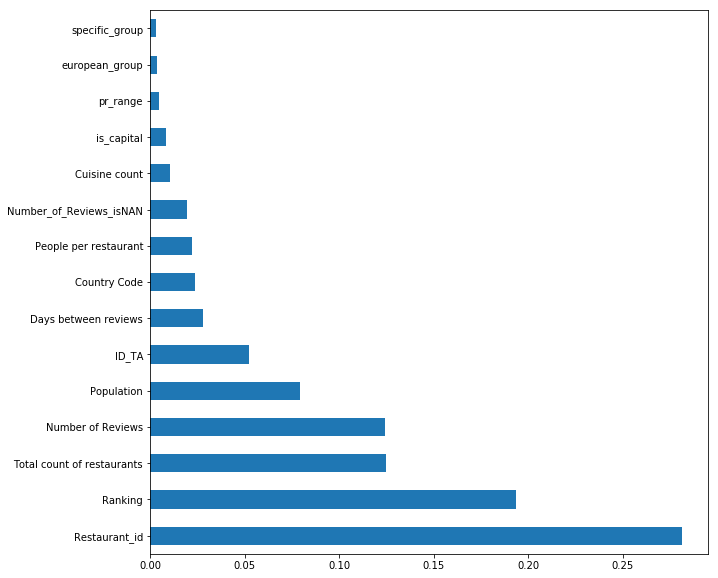

In [77]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [56]:
test_data.sample(10)

,Restaurant_id,Ranking,Number of Reviews,ID_TA,Rating,european_group,middle_eastern_group,asian_group,others_group,healthy_options_group,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
3533,3533,4464.0,342.0,991825,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3431,3431,12523.0,19.0,10346869,0.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7656,7656,7682.0,84.0,7070992,0.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3777,3777,1161.0,14.0,12145157,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4208,4208,1443.0,3.0,11506439,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3669,3669,14255.0,2.0,7797340,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5507,5507,3520.0,155.0,3327836,0.0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
939,939,7316.0,13.0,11797353,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7824,7824,1916.0,128.0,5850652,0.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3064,3064,87.0,226.0,858141,0.0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_data = test_data.drop(['Rating'], axis=1)

In [58]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [59]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [60]:
predict_submission

array([4.645, 4.31 , 4.585, ..., 2.645, 3.29 , 3.915])

In [61]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,4.645
1,id_1,4.310
2,id_2,4.585
3,id_3,4.370
4,id_4,4.430
5,id_5,4.610
6,id_6,4.080
7,id_7,3.920
8,id_8,4.380
9,id_9,4.695


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
